> For discrete, noncontractual business settings

In [341]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.special as sc
import os
from IPython.display import display, Image
import plotly.graph_objs as go
import pprint

## Functions

In [369]:
def shape(df):
    '''TODO: Shapes transactional data into recency and frequency'''
    pass

def i_likelihood(alpha, beta, gamma, delta, x, t_x, n):
    '''Calculates the individual likelihood for a person
    given paramters, frequency, recency, and periods
    '''
    # Summation component
    summation = [sc.beta(alpha+x, beta+t_x-x+i) / sc.beta(alpha, beta)
                 * sc.beta(gamma+1, delta+t_x+i) / sc.beta(gamma, delta) 
                 for i in range(0, n-t_x)]
    
    # First component
    return (sc.beta(alpha+x, beta+n-x) / sc.beta(alpha, beta)
            * sc.beta(gamma, delta+n) / sc.beta(gamma, delta)
            + sum(summation))

def log_likelihood(df, alpha, beta, gamma, delta):
    '''Computes total log-likelihood for given parameters'''
    # Get frequency, recency, and periods lists
    frequency = df.frequency.to_list()
    recency = df.recency.to_list()
    periods = df.periods.to_list()
    
    # Compute individual likelihood first
    indiv_llist = [i_likelihood(alpha, beta, gamma, delta, frequency[i], recency[i], periods[i]) 
                   for i in range(0, len(frequency))]
    
    # Multiply with num_obs
    num_obs = np.array(df.num_obs.to_list())
    
    return np.sum(num_obs * np.log(np.array(indiv_llist)))


def maximize(df):
    '''Maximize log-likelihood by searching for best 
    (alpha, beta, gamma, delta) combination'''
    func = lambda x: -log_likelihood(df, x[0], x[1], x[2], x[3])
    x0 = np.array([1., 1., 1., 1.])
    res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})
    return res.x


def prob_alive(df, x, t_x, p):
    '''Probability for a customer with transaction
    history (x, t_x, n) to be alive at time period p'''
    alpha, beta, gamma, delta = maximize(df)
    n = df.periods.iloc[0]
    indiv_ll = i_likelihood(alpha, beta, gamma, delta, x, t_x, n)
    return (sc.beta(alpha+x, beta+n-x) / sc.beta(alpha, beta)
            * sc.beta(gamma, delta+p) / sc.beta(gamma, delta)
            / indiv_ll)

def prob_alive_df(df, p):
    '''List of probabilities for a customer to be alive
    for all the combinations of (x, t_x)'''
    alpha, beta, gamma, delta = maximize(df)
    n = df.periods.iloc[0]
    
    x_list = df.frequency.to_list()
    t_x_list = df.recency.to_list()
    
    p_list = [sc.beta(alpha+x_list[i], beta+n-x_list[i]) 
               / sc.beta(alpha, beta)
               * sc.beta(gamma, delta+p) / sc.beta(gamma, delta)
               / i_likelihood(alpha, beta, gamma, delta, x_list[i], t_x_list[i], n) 
               for i in range(0, len(x_list))]
    
    return pd.DataFrame({'frequency': x_list,
                         'recency': t_x_list,
                         'p_alive': p_list})

def expected_count(df, n):
    '''Calculates the mean number of transactions
    occurring across the first n transaction opportunities
    '''
    alpha, beta, gamma, delta = maximize(df)
    E_x = [alpha / (alpha+beta) 
           * delta / (gamma-1)
           * (1-sc.gamma(gamma+delta)/sc.gamma(gamma+delta+i)
           * sc.gamma(1+delta+i)/sc.gamma(1+delta))
           for i in range(1, n+1)]
    return pd.DataFrame({'n': np.arange(1, n+1),
                         'E[X(n)]': E_x,
                        })

def pmf(df, x, alpha, beta, gamma, delta):
    '''probabilility of having x transactions in the dataset
    (essentially the pmf)'''
    n = df.periods.iloc[0]
    
    # Summation component
    summation = [sc.comb(i, x)
                 * sc.beta(alpha+x, beta+t_x-x+i) / sc.beta(alpha, beta)
                 * sc.beta(gamma+1, delta+t_x+i) / sc.beta(gamma, delta) 
                 for i in range(0, n-t_x)]
    
    return (sc.comb(n, x)
            * sc.beta(alpha+x, beta+n-x) / sc.beta(alpha, beta)
            * sc.beta(gamma, delta+n) / sc.beta(gamma, delta)
            + sum(summation))


def pmf_df(df):
    '''
    Creates a dataframe for all possible x's
    '''
    alpha, beta, gamma, delta = maximize(df)
    p_x = [pmf(df, i, alpha, beta, gamma, delta)
           for i in range(0, df.periods.loc[0]+1)]
    
    return pd.DataFrame({'x': np.arange(0, df.periods.loc[0]+1),
                         'p': p_x})


def cond_expectations(alpha, beta, gamma, delta, x, t_x, n, p):
    '''The expected number of future transactions
    across the next p transaction opportunities by
    a customer with purchase history (x, t_x, n)'''    
    return (1/i_likelihood(alpha, beta, gamma, delta, x, t_x, n)
            * sc.beta(alpha+x+1, beta+n-x)/sc.beta(alpha, beta)
            * delta/(gamma-1)
            * sc.gamma(gamma+delta)/sc.gamma(1+delta)
            * (sc.gamma(1+delta+n)/sc.gamma(gamma+delta+n)
             - sc.gamma(1+delta+n+p)/sc.gamma(gamma+delta+n+p))
           )


def cond_expectations_df(df, p):
    '''Creates a dataframe for CE for each
    (x, t_x, n) combination'''
    alpha, beta, gamma, delta = maximize(df)
    x_list = df.frequency.to_list()
    t_x_list = df.recency.to_list()
    n_list = df.periods.to_list()
    
    ce_list = [cond_expectations(alpha, beta, gamma, delta,
                                 x_list[i], t_x_list[i], n_list[i], p)
               for i in range(0, len(x_list))]
    
    return pd.DataFrame({'frequency': x_list,
                         'recency': t_x_list,
                         'n': n_list,
                         'ce': ce_list})


def marg_posterior_p(alpha, beta, gamma, delta, x, t_x, n, p):
    '''The marginal posterior distribution of p'''
    b1 = (p**(alpha+x-1) * (1-p)**(beta+n-x-1)
         / sc.beta(alpha, beta)
         * sc.beta(gamma, delta+n)/sc.beta(gamma, delta))
    b2 = [(p**(alpha+x-1) * (1-p)**(beta+t_x-x+i-1)
          / sc.beta(alpha, beta)
          * sc.beta(gamma+1, delta+t_x+i)
          / sc.beta(gamma, delta))
          for i in range(0, n-t_x)]
    return (b1 + sum(b2)) / ilikelihood(alpha, beta, gamma, delta, x, t_x, n)


def marg_posterior_theta(alpha, beta, gamma, delta, x, t_x, n, theta):
    '''The marginal posterior distribution of theta'''
    c1 = (sc.beta(alpha+x, beta+n-x) / sc.beta(alpha, beta)
          * theta**(gamma-1) * (1-theta)**(delta+n-1)
          / sc.beta(gamma, delta))
    c2 = [(sc.beta(alpha+x, beta+t_x-x+i) / sc.beta(alpha, beta)
          * theta**gamma * (1-theta)**(delta+t_x+i-1) / sc.beta(gamma, delta))
          for i in range(0, n-t_x)]
    return (c1 + sum(c2)) / ilikelihood(alpha, beta, gamma, delta, x, t_x, n)

## Donation Data

In [130]:
df = pd.read_csv('../data/discrete-noncontractual.csv')

In [131]:
df.head()

frequency  recency  periods  num_obs
0          6        6        6     1203
1          5        6        6      728
2          4        6        6      512
3          3        6        6      357
4          2        6        6      234

### Parameter Estimation

In [133]:
alpha, beta, gamma, delta = maximize(df)
alpha, beta, gamma, delta

(1.2035222635537741,
 0.7497163225424901,
 0.6567182476391347,
 2.7834424466811885)

### Probability Alive at $t = 6$ given frequency and recency

In [136]:
prob_alive_df(df, 6)

frequency  recency   p_alive
0           6        6  1.000000
1           5        6  1.000000
2           4        6  1.000000
3           3        6  1.000000
4           2        6  1.000000
5           1        6  1.000000
6           5        5  0.561002
7           4        5  0.748898
8           3        5  0.824160
9           2        5  0.864710
10          1        5  0.890062
11          4        4  0.215146
12          3        4  0.472461
13          2        4  0.633745
14          1        4  0.731255
15          3        3  0.102110
16          2        3  0.321252
17          1        3  0.517346
18          2        2  0.071380
19          1        2  0.273754
20          1        1  0.074655
21          0        0  0.116218

> Matches with slide 76 of Lecture 7

### Expected count/mean - E[X(n)]

In [102]:
expected_count(df, 11)

n   E[X(n)]
0    1  0.498543
1    2  0.923349
2    3  1.296874
3    4  1.632310
4    5  1.938137
5    6  2.220169
6    7  2.482581
7    8  2.728487
8    9  2.960276
9   10  3.179829
10  11  3.388654

> Matches E[X(n)] column in `BGBB_2011-01-20.csv` from http://brucehardie.com/notes/010/

## In-Sample Fit (1)

In [156]:
count_df = pd.read_csv('../data/discrete-noncontractual-3.csv')

In [159]:
count_df = (
    count_df
    .merge(pmf_df(df), on='x')
    .assign(
        Model=lambda x: x['p'] * 11104
    )
)
count_df

x  Actual         p        Model
0  0    3464  0.311139  3454.882039
1  1    1823  0.170088  1888.654379
2  2    1430  0.121477  1348.882342
3  3    1085  0.100268  1113.378523
4  4    1036  0.091672  1017.922384
5  5    1063  0.092504  1027.166008
6  6    1203  0.112853  1253.114324

>  Matches up with P(X(n)=x) column in `BGBB_2011-01-20.csv` from http://brucehardie.com/notes/010/

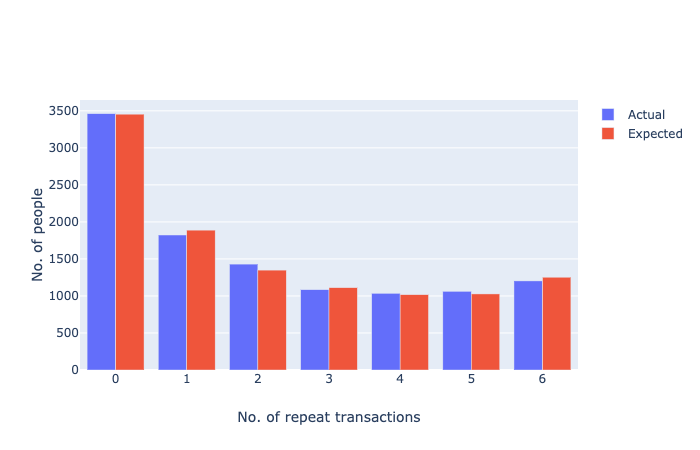

In [162]:
Image(filename='../images/discrete-noncontractual-figure-1.png')

## Tracking Plots (2)

In [166]:
incr_df = pd.read_csv('../data/discrete-noncontractual-2.csv')
# Add a cumulative sum column
incr_df['cumulative'] = incr_df['Actual'].cumsum()
incr_df

Year  Actual  cumulative
0   1996    5652        5652
1   1997    4674       10326
2   1998    4019       14345
3   1999    3552       17897
4   2000    3555       21452
5   2001    3163       24615
6   2002    3110       27725
7   2003    2938       30663
8   2004    2703       33366
9   2005    2573       35939
10  2006    1936       37875

In [168]:
expected_df = (
    expected_count(df, 11)
    .assign(
        model=lambda x: x['E[X(n)]'] * 11104,
        Year=np.arange(1996, 2007),
        annual=lambda x: x['model'].diff()
    )
)
expected_df.loc[0, 'annual'] = expected_df['model'].iloc[0]
expected_df

n   E[X(n)]         model  Year       annual
0    1  0.498543   5535.817992  1996  5535.817992
1    2  0.923349  10252.865461  1997  4717.047470
2    3  1.296874  14400.486526  1998  4147.621064
3    4  1.632310  18125.164970  1999  3724.678444
4    5  1.938137  21521.078432  2000  3395.913462
5    6  2.220169  24652.760154  2001  3131.681723
6    7  2.482581  27566.581970  2002  2913.821815
7    8  2.728487  30297.115423  2003  2730.533453
8    9  2.960276  32870.903600  2004  2573.788177
9   10  3.179829  35308.821051  2005  2437.917451
10  11  3.388654  37627.616052  2006  2318.795001

### Cumulative

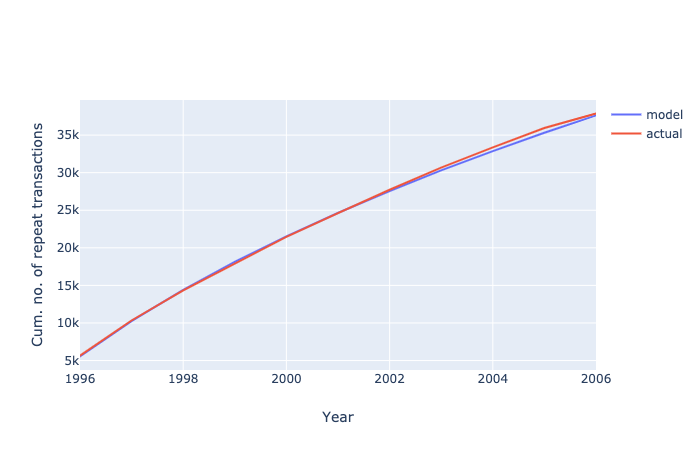

In [169]:
Image('../images/discrete-noncontractual-figure-2.png')

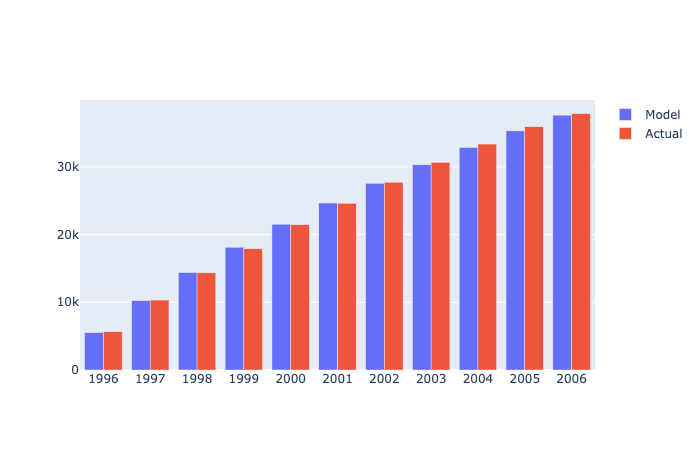

In [178]:
Image('../images/discrete-noncontractual-figure-4.png')

### Annual

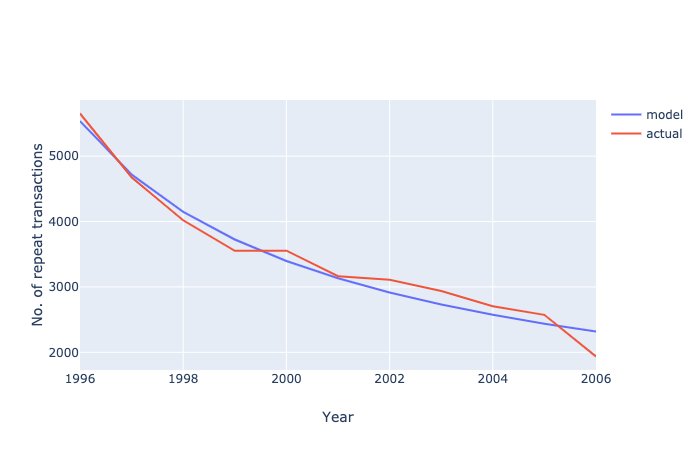

In [170]:
Image('../images/discrete-noncontractual-figure-3.png')

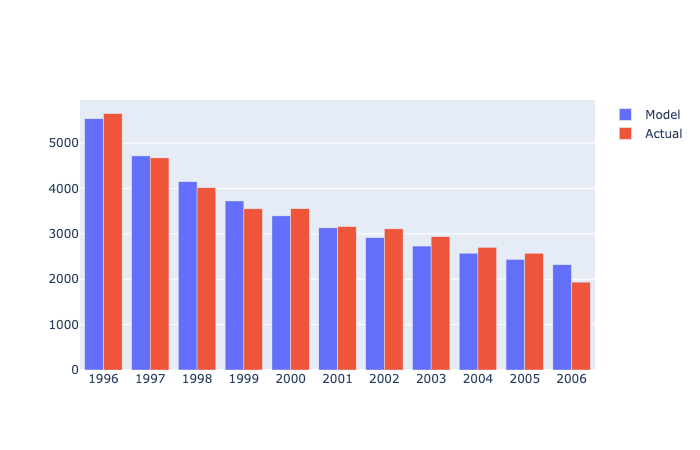

In [179]:
Image('../images/discrete-noncontractual-figure-5.png')

## Conditional Expectation (3)

The expected number of future transactions across the next 5 transaction opportunities by a customer with purchase history (x, t_x, n)

In [220]:
ce_df = cond_expectations_df(df, 5)
ce_df

frequency  recency  n        ce
0           6        6  6  3.752544
1           5        6  6  3.231612
2           4        6  6  2.710681
3           3        6  6  2.189749
4           2        6  6  1.668817
5           1        6  6  1.147885
6           5        5  6  1.812942
7           4        5  6  2.030024
8           3        5  6  1.804703
9           2        5  6  1.443042
10          1        5  6  1.021689
11          4        4  6  0.583192
12          3        4  6  1.034572
13          2        4  6  1.057603
14          1        4  6  0.839396
15          3        3  6  0.223595
16          2        3  6  0.536111
17          1        3  6  0.593853
18          2        2  6  0.119121
19          1        2  6  0.314238
20          1        1  6  0.085696
21          0        0  6  0.072863

> Matches up with CE column in `BGBB_2011-01-20.csv` from http://brucehardie.com/notes/010/

### Expected # Transactions in 2002-2006 as a Function of Recency and Frequency

In [222]:
ce_df.pivot_table(values='ce', index='frequency', columns='recency')

recency           0         1         2         3         4         5  \
frequency                                                               
0          0.072863       NaN       NaN       NaN       NaN       NaN   
1               NaN  0.085696  0.314238  0.593853  0.839396  1.021689   
2               NaN       NaN  0.119121  0.536111  1.057603  1.443042   
3               NaN       NaN       NaN  0.223595  1.034572  1.804703   
4               NaN       NaN       NaN       NaN  0.583192  2.030024   
5               NaN       NaN       NaN       NaN       NaN  1.812942   
6               NaN       NaN       NaN       NaN       NaN       NaN   

recency           6  
frequency            
0               NaN  
1          1.147885  
2          1.668817  
3          2.189749  
4          2.710681  
5          3.231612  
6          3.752544

### CE as a function of Frequency

In [221]:
(
    ce_df
    .groupby('frequency', as_index=False)
    .agg(
        mean_ce=('ce', 'mean')
    )
)

mean_ce
0  0.072863
1  0.667126
2  0.964939
3  1.313154
4  1.774632
5  2.522277
6  3.752544

### CE as a function Recency

In [217]:
(
    ce_df
    .groupby('recency', as_index=False)
    .agg(
        mean_ce=('ce', 'mean')
    )
)

mean_ce
0  0.072863
1  0.085696
2  0.216679
3  0.451186
4  0.878691
5  1.622480
6  2.450215

### Posterior Mean of P as a Function of Recency and Frequency

In [343]:
# TODO

### P(Alive in 2002) as a Function of Recency and Frequency

In [237]:
p_alive_df = prob_alive_df(df, 7)

p_alive_df.pivot_table(values='p_alive', index='frequency', columns='recency')

recency           0         1         2         3         4         5  \
frequency                                                               
0          0.108133       NaN       NaN       NaN       NaN       NaN   
1               NaN  0.069462  0.254710  0.481356  0.680384  0.828144   
2               NaN       NaN  0.066415  0.298904  0.589657  0.804555   
3               NaN       NaN       NaN  0.095006  0.439594  0.766826   
4               NaN       NaN       NaN       NaN  0.200179  0.696800   
5               NaN       NaN       NaN       NaN       NaN  0.521975   
6               NaN       NaN       NaN       NaN       NaN       NaN   

recency           6  
frequency            
0               NaN  
1          0.930434  
2          0.930434  
3          0.930434  
4          0.930434  
5          0.930434  
6          0.930434

## Posterior Distributions

Further insights can be obtained by looking at the marginal posterior distributions of $P$ and $\Theta$

In [251]:
def post_dist(alpha, beta, gamma, delta, x, t_x, n, p, theta):
    '''Joint Posterior of p and theta
    actually i am not sure if this is right'''
    g_p = p**(alpha-1) * (1-p)**(beta-1) / sc.beta(alpha, beta)
    g_theta = theta**(gamma-1) * (1-theta)**(delta-1) / sc.beta(gamma, delta)
    l_p_theta_1 = (p**x) * (1-p)**(n-x) * (1-theta)**n
    l_p_theta_2 = [(p**x) * (1-p)**(t_x-x+i) * theta * (1-theta)**(t_x+i)
                   for i in range(0, n-t_x)]
    l_p_theta = l_p_theta_1 + sum(l_p_theta_2)
    l_abgd = i_likelihood(alpha, beta, gamma, delta, x, t_x, n)
    return l_p_theta * g_p * g_theta / l_abgd

## Marginal Posterior Distributions

### P (purchasing coin)

In [207]:
def beta_distribution(p, alpha, beta):
    return p**(alpha-1) * (1-p)**(beta-1) / sc.beta(alpha, beta) 

In [327]:
def expected_value(darray):
    '''Gets expected value of p in darray'''
    probs = np.array(darray) / np.sum(darray)
    sample = np.random.choice(np.arange(0.00, 1.00, 1.0 / len(darray)), 
                              size=100000, replace=True, p=probs)
    return np.mean(sample)

In [330]:
zerozero = [marg_posterior_p(alpha, beta, gamma, delta, 0, 0, 6, i) for i in np.arange(0.00, 1.00, 0.001)]
threethree = [marg_posterior_p(alpha, beta, gamma, delta, 3, 3, 6, i) for i in np.arange(0.00, 1.00, 0.001)]
threesix = [marg_posterior_p(alpha, beta, gamma, delta, 3, 6, 6, i) for i in np.arange(0.00, 1.00, 0.001)]
p_betas = [beta_distribution(i, alpha, beta) for i in np.arange(0.01, 1.00, 0.001)] # prior

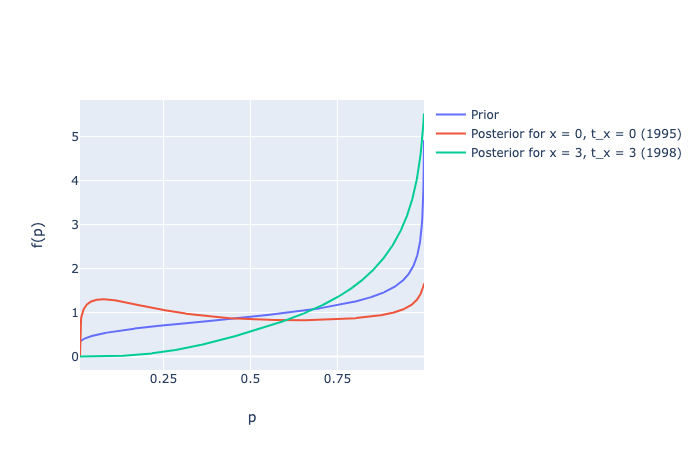

In [339]:
# Slide 78 from Lecture 7
Image("../images/discrete-noncontractual-figure-6.png")

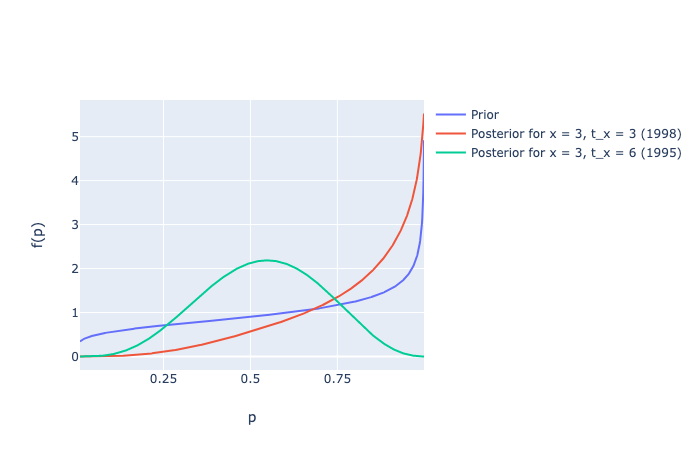

In [338]:
Image("../images/discrete-noncontractual-figure-7.png")

In [349]:
# Expected Values
pp = pprint.PrettyPrinter()
some_dict = {'prior': alpha / (alpha+beta),
             'x = 0, t_x = 0': expected_value(zerozero),
             'x = 3, t_x = 3': expected_value(threethree),
             'x = 3, t_x = 6': expected_value(threesix)}

pp.pprint(some_dict)

{'prior': 0.6161675650485328,
 'x = 0, t_x = 0': 0.48720180999999996,
 'x = 3, t_x = 3': 0.7961373999999999,
 'x = 3, t_x = 6': 0.52880236}


### $\Theta$ (die coin)

In [360]:
threethree_theta = [marg_posterior_theta(alpha, beta, gamma, delta, 3, 3, 6, i) for i in np.arange(0.01, 1.00, 0.001)]
threesix_theta = [marg_posterior_theta(alpha, beta, gamma, delta, 3, 6, 6, i) for i in np.arange(0.01, 1.00, 0.001)]
theta_betas = [beta_distribution(i, gamma, delta) for i in np.arange(0.01, 1.00, 0.001)] # prior

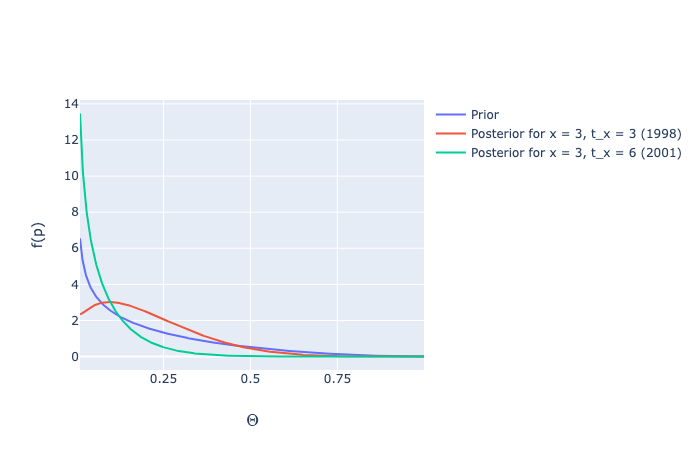

In [366]:
Image('../images/discrete-noncontractual-figure-8.png')

In [368]:
# Expected Values
pp = pprint.PrettyPrinter()
some_dict = {'prior': gamma / (gamma+delta),
             'x = 3, t_x = 3': expected_value(threethree_theta),
             'x = 3, t_x = 6': expected_value(threesix_theta)}

pp.pprint(some_dict)

{'prior': 0.19089754985090407,
 'x = 3, t_x = 3': 0.20083860606060608,
 'x = 3, t_x = 6': 0.07763613131313132}


## DERT

In [370]:
# TODO